# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

Load the run information 

In [2]:
run_info = pd.read_csv('run_data.csv')

Pick one

In [3]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0]
print(run_info)

path                runs/22Jun20-222335-1693ca
param_hash                              1693ca
start_time                 2020-06-22 22:23:03
parallel_guesses                            10
rl_episodes                                 10
search_size                                 10
initial_count                               10
hostname                             thetamom3
worker_count                                 8
n_evals                                     20
Name: 0, dtype: object


## Load in Result File
This file is the list of the quantum chemistry results

In [4]:
result_data = pd.read_json(os.path.join(run_info['path'], 'simulation_records.jsonld'), lines=True)

Plot the time since first result

In [5]:
result_data['walltime'] = result_data['time_result_received'] - result_data['time_created'].min()

Plot the rate at which we aquired new results

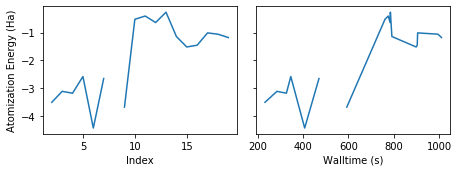

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.5))

axs[0].plot(result_data.index, result_data['value'])
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Atomization Energy (Ha)')

axs[1].plot(result_data['walltime'], result_data['value'])
axs[1].set_xlabel('Walltime (s)')

fig.tight_layout()

## Evaluate Runtimes
Estimate the runtimes of the QC code

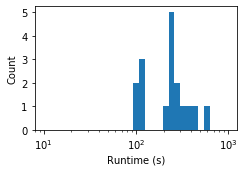

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.hist(result_data['time_running'], bins=np.logspace(1, 3, 32))
ax.set_xscale('log')

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Count')
fig.tight_layout()

## Plot the Number of Results Being Run at a Time
We can look at the "inputs recieved" and "output sent" times to get the number of calculations actively requested on the method server

In [8]:
events = [{'time': t, 'queue_delta': 1} for t in result_data['time_input_received']]
events.extend([{'time': t, 'queue_delta': -1} for t in result_data['time_result_received']])
events = pd.DataFrame(events)

Make the results easier to plot

In [9]:
events.sort_values('time', ascending=True, inplace=True)

In [10]:
events['walltime'] = events['time'] - events['time'].min()

In [11]:
events['queue_length'] = events['queue_delta'].cumsum()

Compute worker utilization

In [12]:
events['has_work'] = events['queue_length'] >= run_info['worker_count']

In [13]:
time_with_work = np.multiply(events['walltime'].iloc[1:].values 
                             - events['walltime'].iloc[:-1].values,
                             events['has_work'].iloc[:-1]).values

In [14]:
events['utilization'] = time_with_work.cumsum() / events['walltime'].iloc[1:]

Plot the queue length and utilization

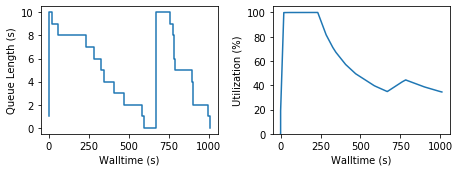

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

# Plot the queue length
ax = axs[0]
ax.step(events['walltime'], events['queue_length'], where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Queue Length (s)')

ax = axs[1]
ax.plot(events['walltime'], events['utilization'] * 100)
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Utilization (%)')
ax.set_ylim(0, 105)

fig.tight_layout()